In [1]:
import matplotlib.pyplot as plt

# look mom no numpy!
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
x, y = [], []
with open("bicycle.txt") as bicycle:
    for line in bicycle:
        row = line.split()
        x.append(float(row[0]))
        y.append(float(row[1]))

data = tf.convert_to_tensor(list(zip(x, y)))
print(data[500:510])

tf.Tensor(
[[0.21965317 0.9447005 ]
 [0.22254336 0.9447005 ]
 [0.22543353 0.9447005 ]
 [0.2283237  0.9447005 ]
 [0.23121387 0.9447005 ]
 [0.23410405 0.9447005 ]
 [0.23699422 0.9447005 ]
 [0.23988439 0.9447005 ]
 [0.24277456 0.9447005 ]
 [0.24566475 0.9447005 ]], shape=(10, 2), dtype=float32)


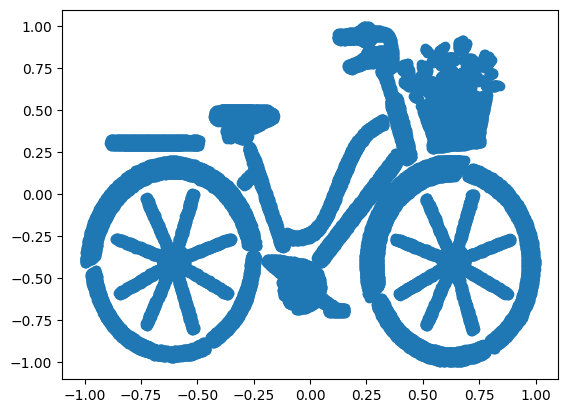

In [3]:
# 2-dimensional distribution of data - target distribution we'll try to approximate
# colorful image of dimensions 32x32x3 will be considered as one point of similar distribution. except 3072-dimensional
plt.scatter(x, y)

In [4]:
# Let's try to add noise to each point

In [5]:
n_steps = 1000  # number of noiseadding steps

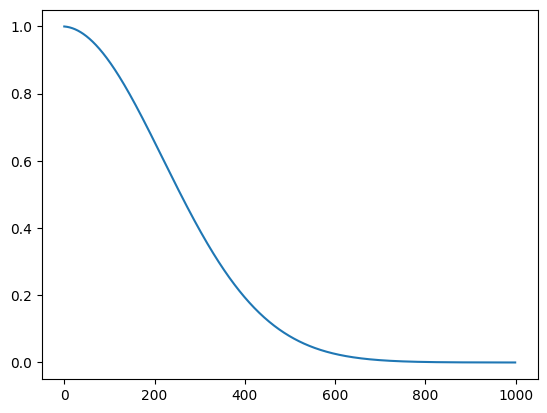

In [6]:
# parameters
betas = tf.linspace(0.0001, 0.02, n_steps)
alphas = 1 - betas
alpha_prods = tf.math.cumprod(alphas)
plt.plot(alpha_prods)

In [7]:
# This method falls down to zero too quickly. We need another one
# turns out if we swap the range to

tf.Tensor(0.49750337, shape=(), dtype=float32)


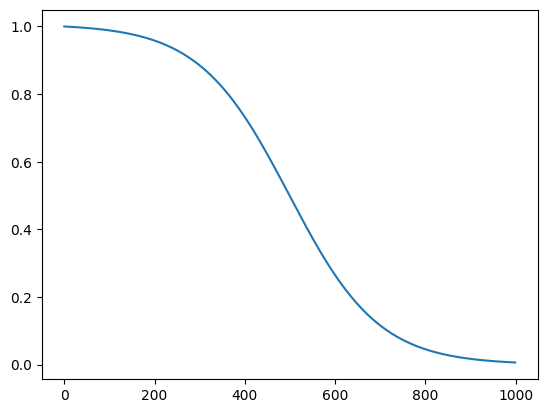

In [8]:
steps = (tf.range(0, n_steps, dtype=tf.float32) - n_steps / 2) / 100
betas = tf.exp(steps) / (1 + tf.exp(steps))
betas = betas * 0.0101188381035  # value chosen by trial and error :)
alphas = 1 - betas
alpha_prods = tf.math.cumprod(alphas)
print(alpha_prods[500])
plt.plot(alpha_prods)

In [9]:
# adding noise to the data

In [10]:
I = tf.eye(2)
N = len(data)

In [11]:
# generate noise for the whole dataset and all iterations
noises = tf.random.normal(shape=(n_steps, N, 2)) * tf.reshape(
    (1 - alpha_prods), (n_steps, 1, 1)
)
noises.shape

TensorShape([1000, 50468, 2])

In [12]:
# generate noise for the "i"th iteration for a group of size 64
n = 64  # number of elements to noise
t = 37  # number of iteration
(tf.random.normal(shape=(n, 2)) * (1 - alpha_prods[t])).shape

TensorShape([64, 2])

In [13]:
# generate new means for all iterations
data_means = data * tf.reshape(tf.sqrt(alpha_prods), (1000, 1, 1))

In [14]:
# generate a mean for a given iteration for a specific part of the dataset
n = 64
t = 37
start = 58
(data[start : start + n] * tf.sqrt(alpha_prods[t])).shape

TensorShape([64, 2])

In [15]:
# generate all iterations
iterations = noises + data_means
# iterations = tf.reshape(iterations,iterations.shape[:2] + [1] + iterations.shape[2])

In [16]:
# function to noise fiven points in a given iteration


def noise(points, t):
    return points * tf.sqrt(alpha_prods[t]) + tf.random.normal(shape=points.shape) * (
        1 - alpha_prods[t]
    )

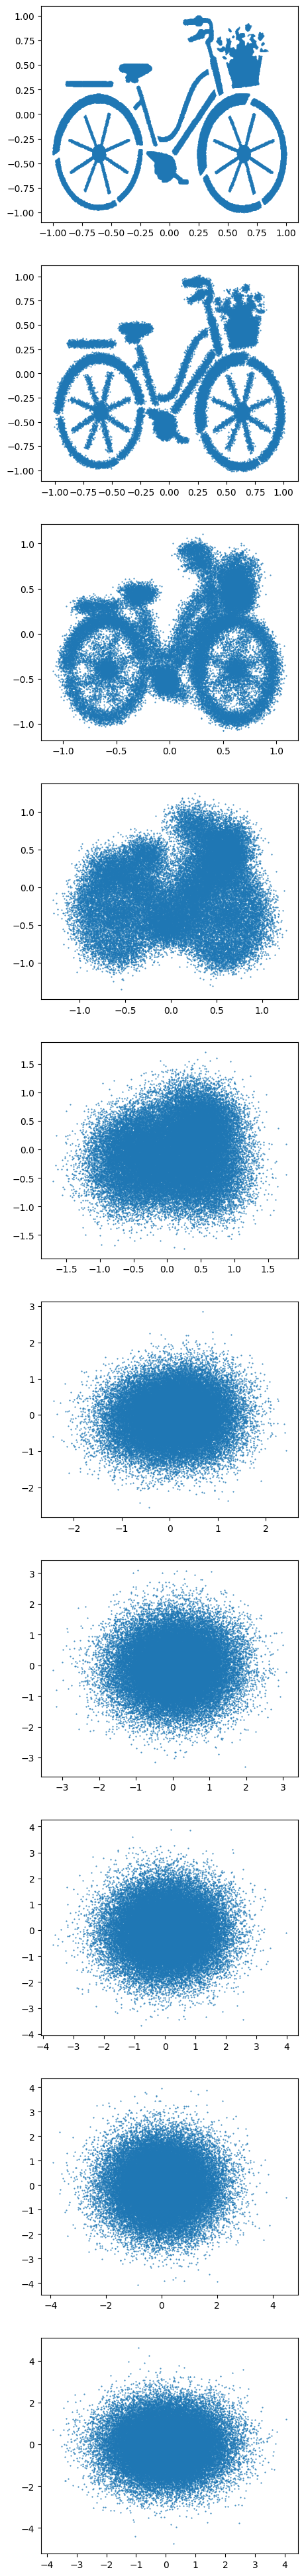

In [17]:
figure, axis = plt.subplots(10, figsize=(5, 50))

for i in range(10):
    d = noise(data, i * 100)
    # axis[i].scatter(iterations[i*100,:,:,0],iterations[i*100,:,:,1],marker=".",s=1)
    axis[i].scatter(d[:, 0], d[:, 1], marker=".", s=1)
plt.show()

# Build a diffusion model

### Create a Learnable Sinusoidal Embedding block

In [18]:
class LearnableSinusoidalEmbedding(layers.Layer):
    def __init__(self, d=25, n=10000, output_size=128):
        super(LearnableSinusoidalEmbedding, self).__init__()
        self.d = d
        self.denominator = tf.cast(tf.math.pow(n, tf.range(d) / d), tf.float32)
        self.dense1 = layers.Dense(128, input_shape=(2 * d,), activation="relu")
        self.dense2 = layers.Dense(output_size, input_shape=(128,))

    def call(self, k):
        k = tf.reshape(k, (-1, tf.shape(k)[0]))
        k = tf.transpose(k)
        # values of cosine and sine can be permuted however we want as we're feeding them to dense layers
        input = tf.concat(
            [tf.sin(k / self.denominator), tf.cos(k / self.denominator)], 1
        )
        output1 = self.dense1(input)
        return self.dense2(output1)

In [19]:
lse = LearnableSinusoidalEmbedding(25)

In [20]:
lse(steps[:3]).shape

TensorShape([3, 128])

### Create a Conditional Dense Layer block

In [21]:
class ConditionalDenseLayer(layers.Layer):
    def __init__(self, d=25, n=10000, output_size=128, relu=True):
        super(ConditionalDenseLayer, self).__init__()
        self.lse = LearnableSinusoidalEmbedding(d, n, output_size)
        self.dense = layers.Dense(output_size)
        self.relu = relu

    def call(self, point, t):
        tensor = self.lse(t) + self.dense(point)
        if self.relu:
            return tf.keras.activations.relu(tensor)
        else:
            return tensor

In [22]:
tf.cast(2, tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=2.0>

In [23]:
cdl = ConditionalDenseLayer()
cdl_output_1 = cdl(tf.cast(iterations[:64, 0], tf.float32), steps[:64])
cdl_output_1.shape

TensorShape([64, 128])

In [24]:
cdl_out = ConditionalDenseLayer(output_size=2, relu=False)
cdl_out(cdl_output_1, tf.cast([2], tf.float32)).shape

TensorShape([64, 2])

### Create a neural network that will learn to approximate the distribution

In [25]:
# first way. Looks like pytorch wow I hate my coding style
class DiffusionNetwork(layers.Layer):
    def __init__(self, d=25, n=10000):
        super(DiffusionNetwork, self).__init__()
        self.cdl1 = ConditionalDenseLayer(d, n)
        self.cdl2 = ConditionalDenseLayer(d, n)
        self.cdl3 = ConditionalDenseLayer(d, n)
        self.cdl4 = ConditionalDenseLayer(d, n, output_size=2, relu=False)

    def call(self, inp):
        point, t = inp[0], inp[1]
        data = self.cdl1(point, t)
        data = self.cdl2(data, t)
        data = self.cdl3(data, t)
        return self.cdl4(data, t)

In [26]:
# another way. Much batter. Maybe... A little? No I don't know. Still a mix of torch and tf
def get_network(d=25, n=10000):
    cdl1 = ConditionalDenseLayer(d, n)
    cdl2 = ConditionalDenseLayer(d, n)
    cdl3 = ConditionalDenseLayer(d, n)
    cdl4 = ConditionalDenseLayer(d, n, output_size=2, relu=False)

    point_input = layers.Input(shape=(2,), name="point_input")
    time_input = layers.Input(shape=(1,), name="time_input")
    out1 = cdl1(point_input, time_input)
    out2 = cdl2(out1, time_input)
    out3 = cdl3(out2, time_input)
    out4 = cdl4(out3, time_input)

    return keras.Model([point_input, time_input], out4)

In [27]:
network = get_network()
network([data[:64], steps[:64]]).shape

TensorShape([64, 2])

In [28]:
diffusion_net = DiffusionNetwork()
diffusion_net([data[:64], steps[:64]]).shape

TensorShape([64, 2])

### Assemble the model

In [29]:
class DiffusionModel(keras.Model):
    def __init__(self, network, n_steps):
        super().__init__()
        self.network = network
        steps = (tf.range(0, n_steps, dtype=tf.float32) - n_steps / 2) / 100
        betas = tf.exp(steps) / (1 + tf.exp(steps))
        self.betas = betas * 0.0101188381035  # value chosen by trial and error :)
        self.alphas = 1 - self.betas
        self.n_steps = n_steps
        self.alpha_prods = tf.math.cumprod(alphas)

    def train_step(self, points):
        t = tf.random.uniform(
            minval=0, maxval=self.n_steps, shape=tf.shape(points)[:1], dtype=tf.int64
        )

        with tf.GradientTape() as tape:
            noise = tf.random.normal(shape=tf.shape(points))
            points_t = (
                points * tf.sqrt(tf.gather(self.alpha_prods, t))[..., None]
                + noise * tf.sqrt(1 - tf.gather(self.alpha_prods, t))[..., None]
            )
            pred_noise = self.network([points_t, t], training=True)
            loss = self.loss(noise, pred_noise)

        gradients = tape.gradient(loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        return {"loss": loss}

    def generate_diffusion(self, points):
        result = []
        for t in range(n_steps - 1, -1, -1):
            if t == 0:
                z = 0
            else:
                z = tf.random.normal(shape=points.shape)
            points = (
                points
                - self.network([points, tf.cast([[t]], tf.float32)])
                * (1 - alphas[t])
                / tf.sqrt(1 - alpha_prods[t])
            ) / tf.sqrt(alphas[t]) + z * tf.sqrt(betas[t])
            if t % 100 == 0:
                result.append(points)
        result.append(points)
        return result

In [30]:
model = DiffusionModel(get_network(), n_steps)
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
)

In [31]:
model.fit(
    x=data,
    epochs=1000,
    batch_size=64,
)

Epoch 1/1000
789/789 [==============================] - 4s 5ms/step - loss: 0.4868
Epoch 2/1000
789/789 [==============================] - 4s 5ms/step - loss: 0.3956
Epoch 3/1000
789/789 [==============================] - 4s 5ms/step - loss: 0.3903
Epoch 4/1000
789/789 [==============================] - 4s 5ms/step - loss: 0.3825
Epoch 5/1000
789/789 [==============================] - 4s 6ms/step - loss: 0.3867
Epoch 6/1000
789/789 [==============================] - 5s 6ms/step - loss: 0.3803
Epoch 7/1000
789/789 [==============================] - 5s 6ms/step - loss: 0.3818
Epoch 8/1000
789/789 [==============================] - 5s 6ms/step - loss: 0.3780
Epoch 9/1000
789/789 [==============================] - 5s 6ms/step - loss: 0.3784
Epoch 10/1000
789/789 [==============================] - 5s 6ms/step - loss: 0.3793
Epoch 11/1000
789/789 [==============================] - 5s 6ms/step - loss: 0.3743
Epoch 12/1000
789/789 [==============================] - 5s 6ms/step - loss: 0.3756
E

In [32]:
normal_input = tf.random.normal(shape=(50000, 2))
predictions = model.generate_diffusion(normal_input)

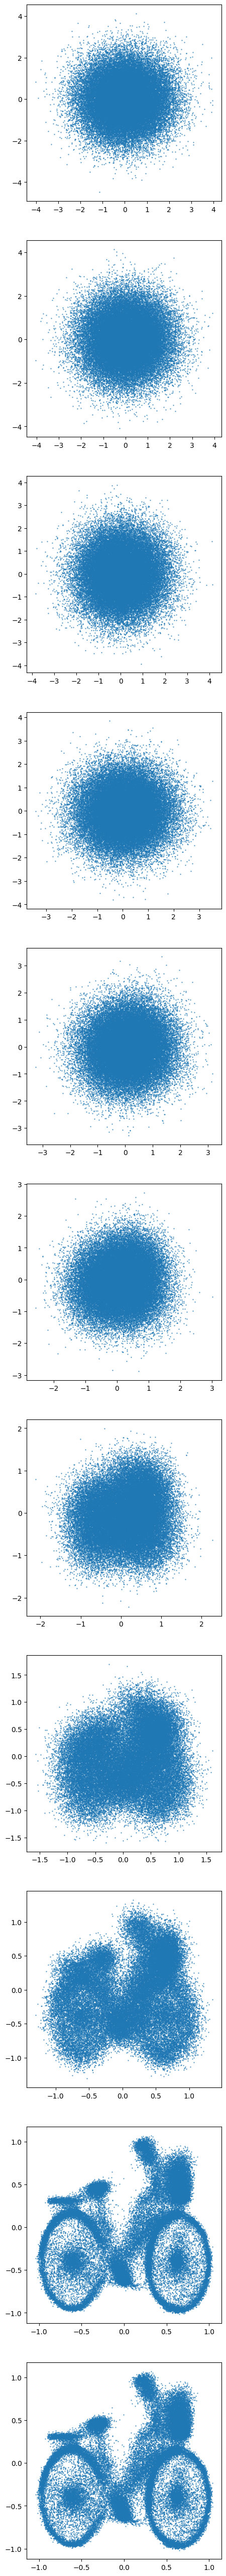

In [33]:
figure, axis = plt.subplots(len(predictions), figsize=(5, 6 * len(predictions)))

for i in range(len(predictions)):
    d = predictions[i]
    axis[i].scatter(d[:, 0], d[:, 1], marker=".", s=1)
plt.show()